In [1]:
import anndata as ad
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import stats
from pysal.explore import esda
from pysal.lib import weights

import seaborn as sns
import matplotlib.colors as mcolors
from scipy.stats import f_oneway

from bin import load_bgi as ld

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/spaghetti/network.py:42: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [316]:
bdata_bin100 = sc.read_h5ad("gRNA/B926/D03658A6.tissue.guide.h5")

In [287]:
mask = bdata_bin100.var_names.str.startswith("sg")
fdata = bdata_bin100[:, ~mask].copy()
cdata = bdata_bin100[:, mask].copy()

In [288]:
sgs = cdata.var_names.str.split('_', n=1).str[0]
sgs_grouped = pd.DataFrame(cdata.X.toarray(), columns=cdata.var_names)
sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()
sgdata = ad.AnnData(sgs_grouped, obs=cdata.obs, var=pd.DataFrame(index=sgs_grouped.columns))
sgdata.obsm['spatial'] = cdata.obsm['spatial']
cdata = sgdata.copy()

In [5]:
fdata_bin20 = ad.read_h5ad("./RNA/B926-1.expr.bin_20.annotation.h5")
cdata_bin20 = ad.read_h5ad("./RNA/B926-1.guide.bin_20.h5")

In [6]:
mask = fdata_bin20.var_names.str.startswith("sg")
fdata_bin20 = fdata_bin20[:, ~mask].copy()

In [7]:
sgs = cdata_bin20.var_names.str.split('_', n=1).str[0]
sgs_grouped = pd.DataFrame(cdata_bin20.X.toarray(), columns=cdata_bin20.var_names)
sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()
sgdata = ad.AnnData(sgs_grouped, obs=cdata_bin20.obs, var=pd.DataFrame(index=sgs_grouped.columns))
sgdata.obsm['spatial'] = cdata_bin20.obsm['spatial']
cdata_bin20 = sgdata.copy()

/tmp/ipykernel_65334/2956383191.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


In [291]:
guide="sgGata3"
threshold = np.quantile(cdata.X, 0.999)
mask = cdata[:, guide].X > threshold

In [ ]:
fdata_bin20

In [303]:
fdata_bin20.obs["spatial_cov"] = [tuple([(array[0] // 100) * 100, (array[1] // 100) * 100]) for array in fdata_bin20.obsm["spatial"]]
cdata_bin20.obs["spatial_cov"] = [tuple([(array[0] // 100) * 100, (array[1] // 100) * 100]) for array in cdata_bin20.obsm["spatial"]]

cdata.obs["spatial_cov"] = [tuple([(array[0] // 100) * 100, (array[1] // 100) * 100]) for array in cdata.obsm["spatial"]]
fdata.obs["spatial_cov"] = [tuple([(array[0] // 100) * 100, (array[1] // 100) * 100]) for array in fdata.obsm["spatial"]]

In [175]:
def extract_bin20(bin20_data, bin100_masked_data, replace_obs=None):

    try:
        bin100_mask = bin100_masked_data.obs["spatial_cov"].tolist()
        mask = [array in bin100_mask for array in bin20_data.obs["spatial_cov"]]
    except:
        bin20_data.obs["spatial_cov"] = [tuple([(array[0] // 100) * 100, (array[1] // 100) * 100]) for array in bin20_data.obsm["spatial"]]
        bin100_masked_data.obs["spatial_cov"] = [tuple([(array[0] // 100) * 100, (array[1] // 100) * 100]) for array in bin100_masked_data.obsm["spatial"]]
        mask = [array in bin100_masked_data.obs["spatial_cov"].tolist() for array in bin20_data.obs["spatial_cov"]]

    if replace_obs:
        for obj in replace_obs:
            spatial_to_obs = dict(zip(bin100_masked_data.obs["spatial_cov"], bin100_masked_data.obs[obj]))
            bin20_data.obs[obj] = bin20_data.obs["spatial_cov"].map(spatial_to_obs)
    return bin20_data[mask].copy()

def extract_bin100(bin100_data, bin20_masked_data):

    try:
        bin20_mask = bin20_masked_data.obs["spatial_cov"].unique().tolist()
        mask = [array in bin20_mask for array in bin100_data.obs["spatial_cov"]]
    except:
        bin100_data.obs["spatial_cov"] = [tuple([(array[0] // 100) * 100, (array[1] // 100) * 100]) for array in bin100_data.obsm["spatial"]]
        bin20_masked_data.obs["spatial_cov"] = [tuple([(array[0] // 100) * 100, (array[1] // 100) * 100]) for array in bin20_masked_data.obsm["spatial"]]
        bin20_mask = bin20_masked_data.obs["spatial_cov"].unique().tolist()
        mask = [array in bin20_mask for array in bin100_data.obs["spatial_cov"]]
    return bin100_data[mask].copy()

def find_near(bin100, bin100_data, border=1, bin_size=100):
    #print("center of bin is ", bin100.obsm["spatial"][0])
    cmin = ((bin100.obsm["spatial"] // bin_size - border) * bin_size)[0]
    cmax = ((bin100.obsm["spatial"] // bin_size + border + 1) * bin_size)[0]
    #print("extracting bin from ", cmin, "to", cmax)
    mask = [cmin[0] <= array[0] <= cmax[0] and cmin[1] <= array[1] <= cmax[1] for array in bin100_data.obsm["spatial"]]
    return bin100_data[mask]

# Major Clone in bin100

center of bin is  [ 1910 11409]
extracting bin from  [ 1700 11200] to [ 2120 11620]


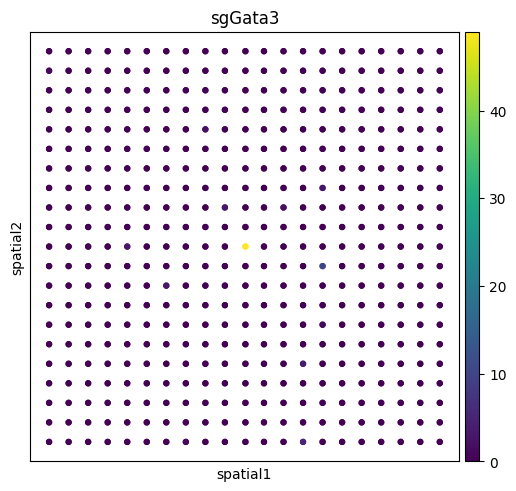

In [34]:
#for i in range(np.sum(mask)):
major_clones = extract_bin20(cdata_bin20, cdata[mask][0])
# max
major_bin20_index = np.argmax(major_clones[:, "sgGata3"].X.toarray())
box_ = find_near(major_clones[major_bin20_index], cdata_bin20, border=10, bin_size=20)
sq.pl.spatial_scatter(box_, color="sgGata3", size=50, shape=None, library_id="spatial")
#break

In [35]:
T_marker = {
    "naive T": ["Ccr7", "Tcf7", "Lef1", "Sell", "Klf2"],
    "memory T": ["Il7r", "Cd27", "Timp1"],
    "Tcm": ["Ccr7", "Sell"],
    "Tem": ["Eomes", "Gzmk"],
    "Trm": ["Cd69", "Itgae", "Xcl1", "Zfp683", "Klf2", "S1pr1"],
    "Temra": ["Tbx21", "Gzmb", "Nkg7"],
    "effector T": ["Gzmk", "Gzma", "Gzmb", "Prf1", "Nkg7"],
    "exhausted T": ["Havcr2", "Lag3", "Entpd1", "Tigit", "Ctla4", "Layn"],
    "stem-like T": ["Tcf7", "Foxo1"]
}

In [36]:
for marker in tqdm(T_marker):
    sc.tl.score_genes(fdata_bin20, T_marker[marker], score_name=f"{marker}_score")

100%|██████████| 9/9 [00:21<00:00,  2.43s/it]


center of bin is  [ 1910 11409]
extracting bin from  [ 1760 11260] to [ 2060 11560]


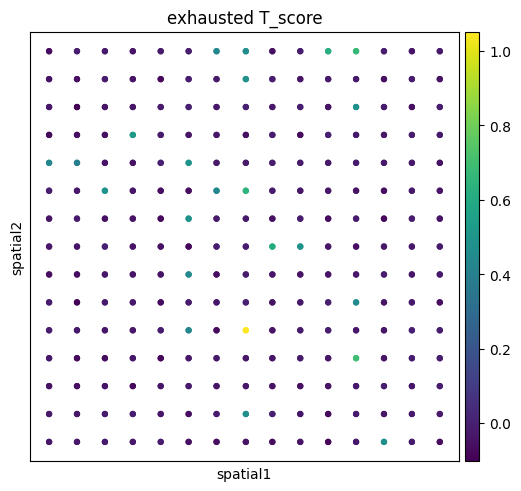

In [37]:
major_clones = extract_bin20(cdata_bin20, cdata[mask][0])

major_bin20_index = np.argmax(major_clones[:, "sgGata3"].X.toarray())
box_ = find_near(major_clones[major_bin20_index], fdata_bin20, border=7, bin_size=20)
sq.pl.spatial_scatter(box_, color="exhausted T_score", size=50, shape=None, library_id="spatial")

In [46]:
fdata.obsm["spatial"]

array([[5749,  449],
       [3649,  648],
       [3849,  749],
       ...,
       [   8, 4750],
       [2049,  249],
       [2349,  249]])

# Correlation

In [131]:
r_df = pd.DataFrame(columns=["r", "p_value"])
for i in tqdm(range(np.sum(mask))):
    major_clones = extract_bin20(cdata_bin20, cdata[mask][i])
    major_bin20_index = np.argmax(major_clones[:, "sgGata3"].X.toarray())
    box_ = find_near(major_clones[major_bin20_index], fdata_bin20, border=4, bin_size=20)
    t_vec = box_.obs["memory T_score"].tolist()

    box_ = find_near(major_clones[major_bin20_index], cdata_bin20, border=4, bin_size=20)
    g_vec = box_[:, "sgGata3"].X.toarray().flatten()

    r = spearmanr(t_vec, g_vec)
    r_df.loc[i] = [r[0], r[1]]

100%|██████████| 119/119 [02:44<00:00,  1.39s/it]


In [132]:
r_df

,r,p_value
0,0.110921,0.324221
1,0.105683,0.347733
2,0.242692,0.029034
3,0.055225,0.624363
4,0.081291,0.470637
...,...,...
114,0.112097,0.319085
115,0.055701,0.621378
116,-0.071407,0.526416
117,-0.051597,0.647343


<Axes: >

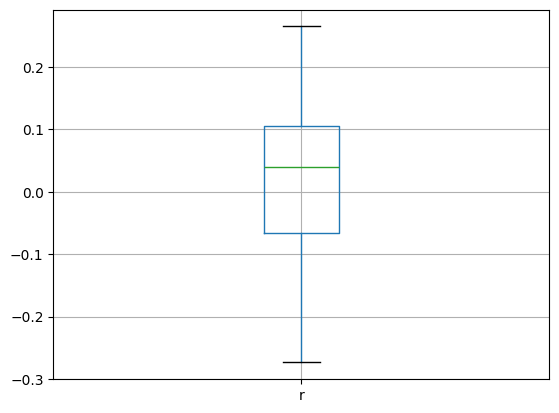

In [139]:
r_df.boxplot("r")

In [176]:
memory_r_dict = r_dict

In [177]:
r_dict = {}
for guide in cdata.var_names:
    print(guide)
    mask = cdata[:, guide].X > threshold
    r_dict[guide] = []
    for i in tqdm(range(np.sum(mask))):
        major_clones = extract_bin20(cdata_bin20, cdata[mask][i])
        major_bin20_index = np.argmax(major_clones[:, guide].X.toarray())
        box_ = find_near(major_clones[major_bin20_index], fdata_bin20, border=4, bin_size=20)
        t_vec = box_.obs["exhausted T_score"].tolist()

        box_ = find_near(major_clones[major_bin20_index], cdata_bin20, border=4, bin_size=20)
        g_vec = box_[:, guide].X.toarray().flatten()

        r = spearmanr(t_vec, g_vec)
        r_dict[guide].append(r[0])

sgAdrb2


100%|██████████| 19/19 [00:09<00:00,  2.09it/s]


sgAqp3


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


sgArntl


100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


sgCd44


100%|██████████| 11/11 [00:04<00:00,  2.33it/s]


sgCd52


100%|██████████| 6/6 [00:02<00:00,  2.34it/s]


sgCxcl16


100%|██████████| 39/39 [00:16<00:00,  2.40it/s]


sgDdit3


100%|██████████| 25/25 [00:10<00:00,  2.34it/s]


sgErgic2


100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


sgFbxo7


100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


sgFlot1


100%|██████████| 23/23 [00:09<00:00,  2.33it/s]


sgGata3


100%|██████████| 119/119 [00:50<00:00,  2.35it/s]


sgGlb1l2


100%|██████████| 11/11 [00:04<00:00,  2.32it/s]


sgGpa33


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


sgIkbip


100%|██████████| 9/9 [00:03<00:00,  2.36it/s]


sgKcna3


100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


sgKlrd1


100%|██████████| 6/6 [00:02<00:00,  2.07it/s]


sgL3mbtl3


100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


sgMark3


100%|██████████| 23/23 [00:10<00:00,  2.19it/s]


sgMcoln1


100%|██████████| 14/14 [00:06<00:00,  2.33it/s]


sgNmb


100%|██████████| 9/9 [00:03<00:00,  2.31it/s]


sgPiezo1


100%|██████████| 9/9 [00:03<00:00,  2.52it/s]


sgPomt1


0it [00:00, ?it/s]


sgPpia


100%|██████████| 32/32 [00:15<00:00,  2.12it/s]


sgS100a11


100%|██████████| 11/11 [00:05<00:00,  1.95it/s]


sgScamp4


100%|██████████| 27/27 [00:11<00:00,  2.35it/s]


sgSlc39a8


100%|██████████| 17/17 [00:07<00:00,  2.38it/s]


sgSorl1


100%|██████████| 19/19 [00:07<00:00,  2.40it/s]


sgSrgn


100%|██████████| 4/4 [00:01<00:00,  2.44it/s]


sgTmem64


100%|██████████| 26/26 [00:12<00:00,  2.09it/s]


sgWipf1


100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


sgZc3h12a


100%|██████████| 172/172 [01:15<00:00,  2.28it/s]


sgZhx2


100%|██████████| 31/31 [00:12<00:00,  2.41it/s]


sgZscan12


100%|██████████| 12/12 [00:05<00:00,  2.09it/s]


sgnon-targeting


100%|██████████| 26/26 [00:10<00:00,  2.41it/s]


In [142]:
r_dict

{'sgAdrb2': [-0.10998260395483977,
  0.07650920556760059,
  -0.21758100019092452,
  0.009564190694860527,
  -0.18397775691819485,
  -0.0901407000790973,
  0.10240646205087454,
  0.15961540554546588,
  0.132147738569982,
  -0.129109284395326,
  0.014345476043925111,
  0.0655300242392201,
  -0.0030246505295220155,
  0.15201975753806576,
  -0.10042116718170341,
  0.18649224148864135,
  0.17692753787507634,
  -0.149200084874904,
  0.1195523836857566],
 'sgAqp3': [-0.34971081227471906,
  -0.13389110974330104,
  0.13389110974330104,
  0.0633424711947165,
  0.0765178462820183,
  0.12432745904735097,
  0.07650963753380156],
 'sgArntl': [0.14345476043925112,
  0.129109284395326,
  0.033473533395883534,
  0.08134607633498575,
  -0.16736388717912629,
  0.13257227980703756,
  -0.004781852345862598,
  0.08607334222552679],
 'sgCd44': [-0.09563650695950074,
  0.1147864931090867,
  -0.107362875301004,
  0.028690952087850222,
  -0.0901407000790973,
  0.132147738569982,
  -0.02391209703577667,
  0.0573

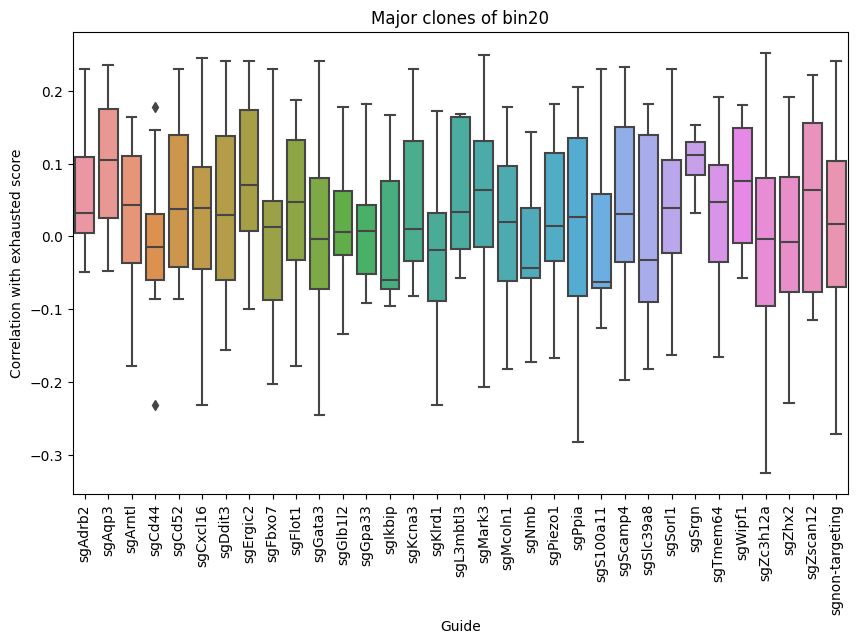

In [179]:
long_format_data = pd.DataFrame([(k, v) for k, lst in r_dict.items() for v in lst], columns=['guide', 'value'])

plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='guide', y='value', data=long_format_data)

plt.xlabel('Guide')
plt.ylabel('Correlation with exhausted score')
plt.title('Major clones of bin20')
plt.xticks(rotation=90)

plt.show()

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scipy/stats/_stats_py.py:4102: DegenerateDataWarning: at least one input has length 0
  if _f_oneway_is_too_small(samples):


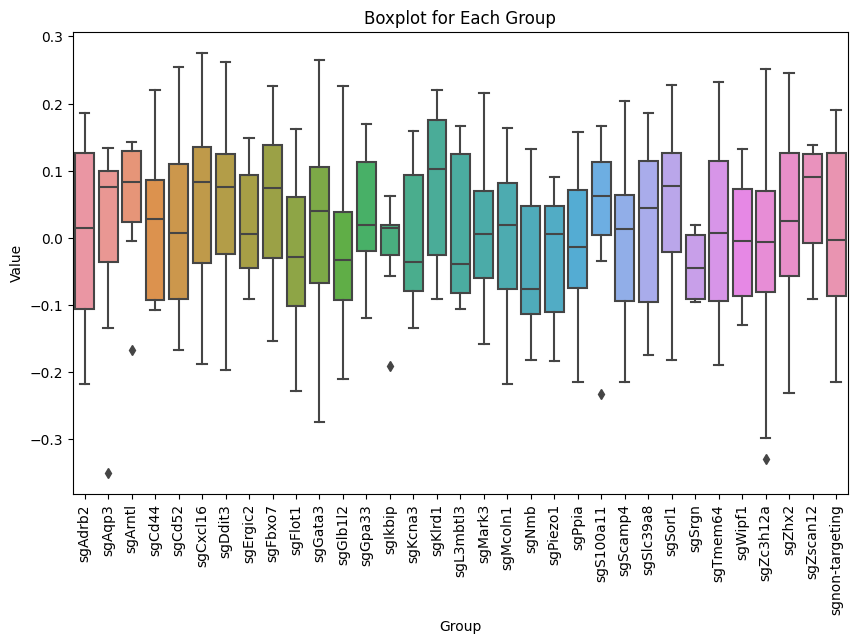

In [173]:
long_format_data = pd.DataFrame([(k, v) for k, lst in r_dict.items() for v in lst], columns=['group', 'value'])
non_targeting_data = long_format_data[long_format_data['group'] == 'sgnon-targeting']['value']

anova_results = {}
for key in r_dict:
    if key != 'sgnon-targeting':
        group_data = long_format_data[long_format_data['group'] == key]['value']
        f_val, p_val = f_oneway(non_targeting_data, group_data)
        anova_results[key] = p_val

plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='group', y='value', data=long_format_data)
plt.xlabel('Group')
plt.ylabel('Value')
plt.xticks(rotation=90)
plt.title('Boxplot for Each Group')

# y_max = long_format_data['value'].max()
# step = (y_max - long_format_data['value'].min()) * 0.1

# for i, (key, p_val) in enumerate(anova_results.items()):
#     x = list(r_dict.keys()).index(key)
#     y = y_max + step
#     plt.text(x + 5, y, p_val, ha='center', va='bottom', color='k', rotation=45)

plt.show()

# Autocorrelation

In [181]:
guide = "sgGata3"
mask = cdata[:, guide].X > threshold

In [236]:
moran_df = pd.DataFrame(columns=["I", "p_value", "z_score"])
for i in tqdm(range(np.sum(mask))):
    major_clones = extract_bin20(cdata_bin20, cdata[mask][i])

    major_bin20_index = np.argmax(major_clones[:, "sgGata3"].X.toarray())
    box_ = find_near(major_clones[major_bin20_index], fdata_bin20, border=13, bin_size=20)

    spatial_coords = box_.obsm["spatial"]
    scores = box_.obs["memory T_score"].tolist()
    w = weights.DistanceBand.from_array(spatial_coords, threshold=21, binary=True)
    moran = esda.Moran(scores, w)

    moran_df.loc[i] = [moran.I, moran.p_sim, moran.z_sim]

100%|██████████| 119/119 [00:45<00:00,  2.61it/s]


In [239]:
moran_df

,I,p_value,z_score
0,-0.013490,0.343,-0.469460
1,-0.031551,0.148,-1.076359
2,0.025936,0.154,1.058144
3,0.020616,0.187,0.835168
4,-0.010440,0.378,-0.351284
...,...,...,...
114,0.028744,0.139,1.116844
115,-0.008018,0.430,-0.232000
116,0.020893,0.171,0.956528
117,0.016054,0.245,0.672012


In [278]:
moran_df = pd.DataFrame(columns=["I", "p_value", "z_score"])
for i in tqdm(range(np.sum(mask))):
    major_clones = extract_bin20(cdata_bin20, cdata[mask][i])

    major_bin20_index = np.argmax(major_clones[:, "sgGata3"].X.toarray())
    box_ = find_near(major_clones[major_bin20_index], fdata_bin20, border=13, bin_size=20)

    spatial_coords = box_.obsm["spatial"]
    scores = (box_.obs["annotations"] == "memory T").tolist()
    w = weights.DistanceBand.from_array(spatial_coords, threshold=21, binary=True)
    moran = esda.Moran(scores, w)

    moran_df.loc[i] = [moran.I, moran.p_sim, moran.z_sim]

100%|██████████| 119/119 [00:34<00:00,  3.42it/s]


In [279]:
moran_df

,I,p_value,z_score
0,-0.008299,0.372,-0.297916
1,-0.012269,0.307,-0.388353
2,-0.007021,0.248,-0.229677
3,-0.004132,0.348,-0.110127
4,-0.005517,0.435,-0.166259
...,...,...,...
114,-0.006791,0.336,-0.225778
115,-0.009811,0.255,-0.325997
116,-0.012500,0.384,-0.441073
117,-0.013676,0.305,-0.469269


In [240]:
guide_df = pd.DataFrame(columns=["I", "p_value", "z_score"])
for i in tqdm(range(np.sum(mask))):
    major_clones = extract_bin20(cdata_bin20, cdata[mask][i])

    major_bin20_index = np.argmax(major_clones[:, "sgGata3"].X.toarray())
    box_ = find_near(major_clones[major_bin20_index], cdata_bin20, border=13, bin_size=20)

    spatial_coords = box_.obsm["spatial"]
    scores = box_[:, "sgGata3"].X.toarray().flatten()
    w = weights.DistanceBand.from_array(spatial_coords, threshold=21, binary=True)
    moran = esda.Moran(scores, w)

    guide_df.loc[i] = [moran.I, moran.p_sim, moran.z_sim]

100%|██████████| 119/119 [00:37<00:00,  3.19it/s]


In [241]:
guide_df

,I,p_value,z_score
0,-0.005303,0.201,-0.377041
1,-0.003472,0.226,-0.192519
2,-0.001709,0.430,-0.213117
3,-0.016784,0.070,-0.676640
4,-0.003228,0.237,-0.122744
...,...,...,...
114,-0.005136,0.135,-0.200996
115,-0.006136,0.040,-0.249711
116,-0.005599,0.167,-0.308892
117,-0.003916,0.448,-0.366157


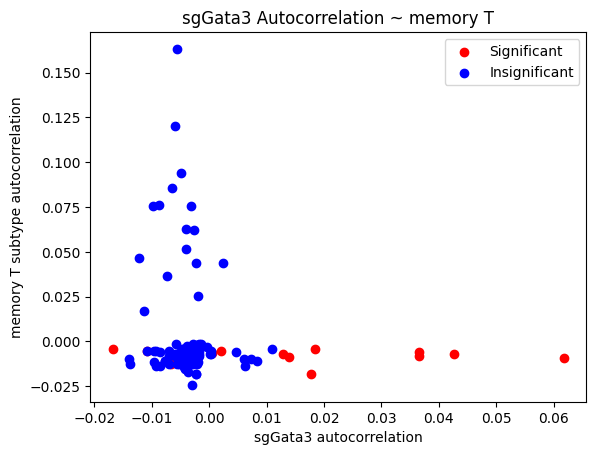

In [281]:
sig = guide_df["p_value"] < 0.1

plt.scatter(guide_df[sig]["I"], moran_df[sig]["I"], color="#FF0000", label="Significant")
plt.scatter(guide_df[~sig]["I"], moran_df[~sig]["I"], color="#0000FF", label="Insignificant")
plt.title("sgGata3 Autocorrelation ~ memory T")
plt.xlabel("sgGata3 autocorrelation")
plt.ylabel("memory T subtype autocorrelation")
plt.legend()
plt.show()

In [247]:
moran_df.iloc[92]

I          0.013722
p_value    0.283000
z_score    0.564023
Name: 92, dtype: float64

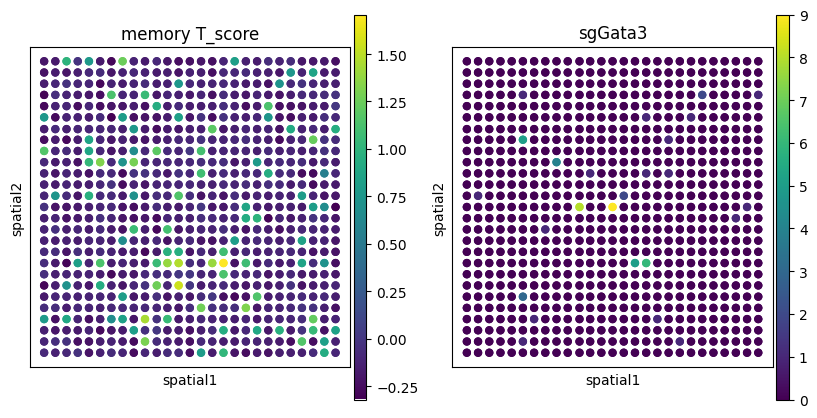

In [245]:
i = 92
major_clones = extract_bin20(cdata_bin20, cdata[mask][i])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
major_bin20_index = np.argmax(major_clones[:, "sgGata3"].X.toarray())
box_ = find_near(major_clones[major_bin20_index], fdata_bin20, border=13, bin_size=20)
sq.pl.spatial_scatter(box_, color="memory T_score", size=100, shape=None, library_id="spatial", ax=ax[0])
box_ = find_near(major_clones[major_bin20_index], cdata_bin20, border=13, bin_size=20)
sq.pl.spatial_scatter(box_, color="sgGata3", size=100, shape=None, library_id="spatial", ax=ax[1])

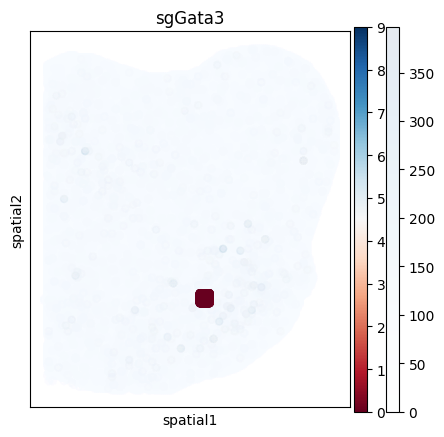

In [246]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sq.pl.spatial_scatter(cdata, color="sgGata3", size=100, shape=None, library_id="spatial", ax=ax, alpha=0.1, cmap="Blues")
sq.pl.spatial_scatter(box_, color="sgGata3", size=100, shape=None, library_id="spatial", ax=ax, cmap="RdBu")

In [213]:
moran_i = {}
major_clones = extract_bin20(cdata_bin20, cdata[mask][92])

major_bin20_index = np.argmax(major_clones[:, "sgGata3"].X.toarray())
for i in range(1, 21):
    box_ = find_near(major_clones[major_bin20_index], cdata_bin20, border=i, bin_size=20)
    spatial_coords = box_.obsm["spatial"]
    scores = box_[:, "sgGata3"].X.toarray().flatten()
    w = weights.DistanceBand.from_array(spatial_coords, threshold=21, binary=True)
    moran = esda.Moran(scores, w)
    moran_i[i] = [moran.I, moran.p_sim, moran.z_sim]

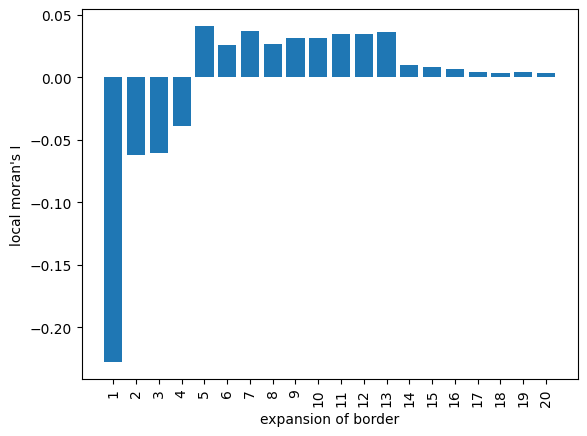

In [248]:
range_df = pd.DataFrame(moran_i, index=["I", "p_value", "z_score"]).T
plt.bar(range_df.index.astype(int), range_df["I"])
plt.xticks(rotation=90, ticks=range(1, 21))
plt.xlabel("expansion of border")
plt.ylabel("local moran's I")
plt.show()

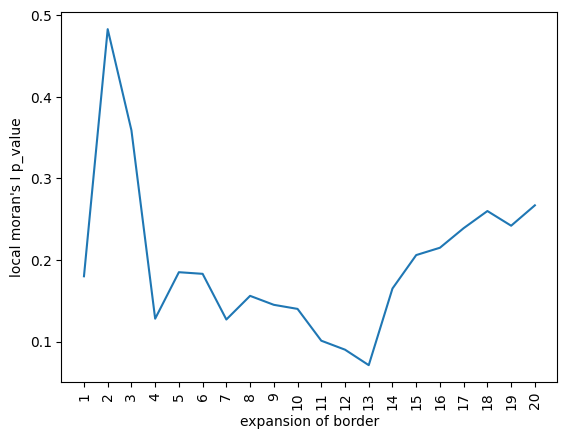

In [237]:
range_df = pd.DataFrame(moran_i, index=["I", "p_value", "z_score"]).T
plt.plot(range_df.index.astype(int), range_df["p_value"])
plt.xticks(rotation=90, ticks=range(1, 21))
plt.xlabel("expansion of border")
plt.ylabel("local moran's I p_value")
plt.show()

# Correlation and autocorrelation

In [260]:
np.array(r_dict["sgGata3"])[sig]

array([-0.02135932, -0.05452171, -0.00622942, -0.07651093,  0.06568771,
       -0.072041  ,  0.10809184,  0.14905125, -0.16808552,  0.04036232,
        0.09492177, -0.00896454, -0.00601996,  0.15232132, -0.02305343,
        0.04713536])

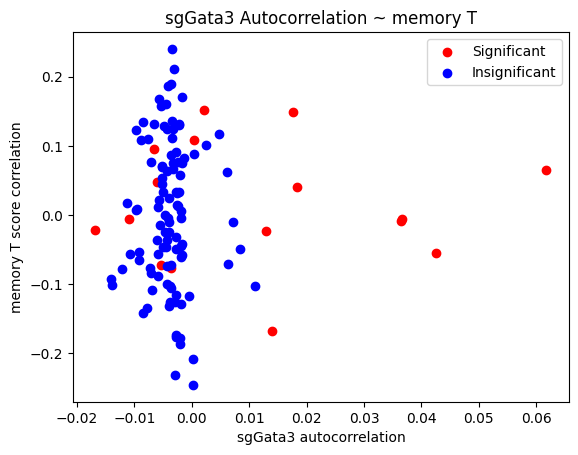

In [262]:
sig = guide_df["p_value"] < 0.1

plt.scatter(guide_df[sig]["I"], np.array(r_dict["sgGata3"])[sig], color="#FF0000", label="Significant")
plt.scatter(guide_df[~sig]["I"], np.array(r_dict["sgGata3"])[~sig], color="#0000FF", label="Insignificant")
plt.title("sgGata3 Autocorrelation ~ memory T")
plt.xlabel("sgGata3 autocorrelation")
plt.ylabel("memory T score correlation")
plt.legend()
plt.show()

In [269]:
np.where(guide_df["I"] > 0.015)

(array([13, 20, 42, 65, 72, 92]),)

In [267]:
np.array(r_dict["sgGata3"])[guide_df["I"] > 0.015]

array([-0.05452171, -0.00622942,  0.06568771,  0.14905125,  0.04036232,
       -0.00896454])

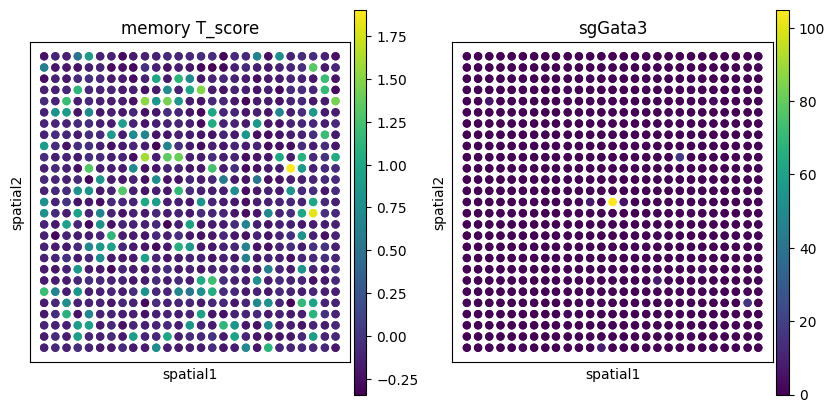

In [277]:
i = 65
major_clones = extract_bin20(cdata_bin20, cdata[mask][i])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
major_bin20_index = np.argmax(major_clones[:, "sgGata3"].X.toarray())
box_ = find_near(major_clones[major_bin20_index], fdata_bin20, border=13, bin_size=20)
sq.pl.spatial_scatter(box_, color="memory T_score", size=100, shape=None, library_id="spatial", ax=ax[0])
box_ = find_near(major_clones[major_bin20_index], cdata_bin20, border=13, bin_size=20)
sq.pl.spatial_scatter(box_, color="sgGata3", size=100, shape=None, library_id="spatial", ax=ax[1])

# bin 50

In [283]:
bdata_bin50 = ld.load_bin("./gRNA/B926/cut.combined.D03658A6.merged.sgRNA.gem", bin_size=50, library_id="rna")

In [284]:
bdata_bin50.write_h5ad("./gRNA/B926/D03658A6.tissue.guide.bin50.h5")

In [289]:
mask = bdata_bin50.var_names.str.startswith("sg")
fdata_bin50 = bdata_bin50[:, ~mask].copy()
cdata_bin50 = bdata_bin50[:, mask].copy()

sgs = cdata_bin50.var_names.str.split('_', n=1).str[0]
sgs_grouped = pd.DataFrame(cdata_bin50.X.toarray(), columns=cdata_bin50.var_names)
sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()
sgdata = ad.AnnData(sgs_grouped, obs=cdata_bin50.obs, var=pd.DataFrame(index=sgs_grouped.columns))
sgdata.obsm['spatial'] = cdata_bin50.obsm['spatial']
cdata_bin50 = sgdata.copy()

In [293]:
for marker in tqdm(T_marker):
    sc.tl.score_genes(fdata_bin50, T_marker[marker], score_name=f"{marker}_score")

100%|██████████| 9/9 [00:10<00:00,  1.19s/it]


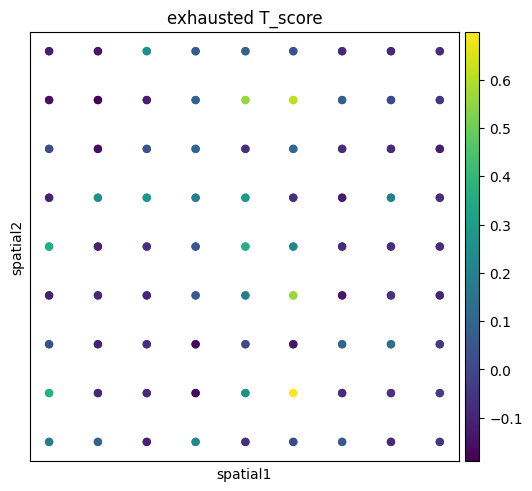

In [317]:
major_clones = extract_bin20(cdata_bin50, cdata[mask][0])

major_bin50_index = np.argmax(major_clones[:, "sgGata3"].X.toarray())
box_ = find_near(major_clones[major_bin50_index], fdata_bin50, border=4, bin_size=50)
sq.pl.spatial_scatter(box_, color="exhausted T_score", size=100, shape=None, library_id="spatial")

In [318]:
cdata_bin50.obs["spatial_cov"] = [tuple([(array[0] // 100) * 100, (array[1] // 100) * 100]) for array in cdata_bin50.obsm["spatial"]]
fdata_bin50.obs["spatial_cov"] = [tuple([(array[0] // 100) * 100, (array[1] // 100) * 100]) for array in fdata_bin50.obsm["spatial"]]

In [304]:
r_dict = {}
for guide in cdata.var_names:
    print(guide)
    mask = cdata[:, guide].X > threshold
    r_dict[guide] = []
    for i in tqdm(range(np.sum(mask))):
        major_clones = extract_bin20(cdata_bin50, cdata[mask][i])
        major_bin20_index = np.argmax(major_clones[:, guide].X.toarray())
        box_ = find_near(major_clones[major_bin20_index], fdata_bin50, border=4, bin_size=20)
        t_vec = box_.obs["exhausted T_score"].tolist()

        box_ = find_near(major_clones[major_bin20_index], cdata_bin50, border=4, bin_size=20)
        g_vec = box_[:, guide].X.toarray().flatten()

        r = spearmanr(t_vec, g_vec)
        r_dict[guide].append(r[0])

sgAdrb2


100%|██████████| 19/19 [00:02<00:00,  9.19it/s]


sgAqp3


100%|██████████| 7/7 [00:00<00:00,  9.82it/s]


sgArntl


100%|██████████| 8/8 [00:00<00:00, 13.76it/s]


sgCd44


100%|██████████| 11/11 [00:00<00:00, 13.64it/s]


sgCd52


100%|██████████| 6/6 [00:00<00:00, 13.83it/s]


sgCxcl16


100%|██████████| 39/39 [00:02<00:00, 14.24it/s]


sgDdit3


100%|██████████| 25/25 [00:01<00:00, 13.99it/s]


sgErgic2


100%|██████████| 10/10 [00:00<00:00, 13.13it/s]


sgFbxo7


100%|██████████| 16/16 [00:01<00:00,  9.30it/s]


sgFlot1


100%|██████████| 23/23 [00:02<00:00,  8.95it/s]


sgGata3


100%|██████████| 119/119 [00:11<00:00, 10.19it/s]


sgGlb1l2


100%|██████████| 11/11 [00:01<00:00,  9.11it/s]


sgGpa33


100%|██████████| 13/13 [00:01<00:00, 11.88it/s]


sgIkbip


100%|██████████| 9/9 [00:00<00:00, 13.20it/s]


sgKcna3


100%|██████████| 10/10 [00:01<00:00,  9.90it/s]


sgKlrd1


100%|██████████| 6/6 [00:00<00:00,  9.19it/s]


sgL3mbtl3


100%|██████████| 8/8 [00:00<00:00,  9.96it/s]


sgMark3


100%|██████████| 23/23 [00:01<00:00, 13.24it/s]


sgMcoln1


100%|██████████| 14/14 [00:01<00:00, 13.40it/s]


sgNmb


100%|██████████| 9/9 [00:00<00:00, 13.17it/s]


sgPiezo1


100%|██████████| 9/9 [00:00<00:00, 14.20it/s]


sgPomt1


0it [00:00, ?it/s]


sgPpia


100%|██████████| 32/32 [00:02<00:00, 13.61it/s]


sgS100a11


100%|██████████| 11/11 [00:00<00:00, 13.28it/s]


sgScamp4


100%|██████████| 27/27 [00:02<00:00, 13.47it/s]


sgSlc39a8


100%|██████████| 17/17 [00:01<00:00, 13.72it/s]


sgSorl1


100%|██████████| 19/19 [00:01<00:00, 13.75it/s]


sgSrgn


100%|██████████| 4/4 [00:00<00:00, 14.09it/s]


sgTmem64


100%|██████████| 26/26 [00:02<00:00, 10.98it/s]


sgWipf1


100%|██████████| 7/7 [00:00<00:00,  9.03it/s]


sgZc3h12a


100%|██████████| 172/172 [00:13<00:00, 12.91it/s]


sgZhx2


100%|██████████| 31/31 [00:02<00:00, 13.96it/s]


sgZscan12


100%|██████████| 12/12 [00:00<00:00, 13.88it/s]


sgnon-targeting


100%|██████████| 26/26 [00:02<00:00, 12.70it/s]


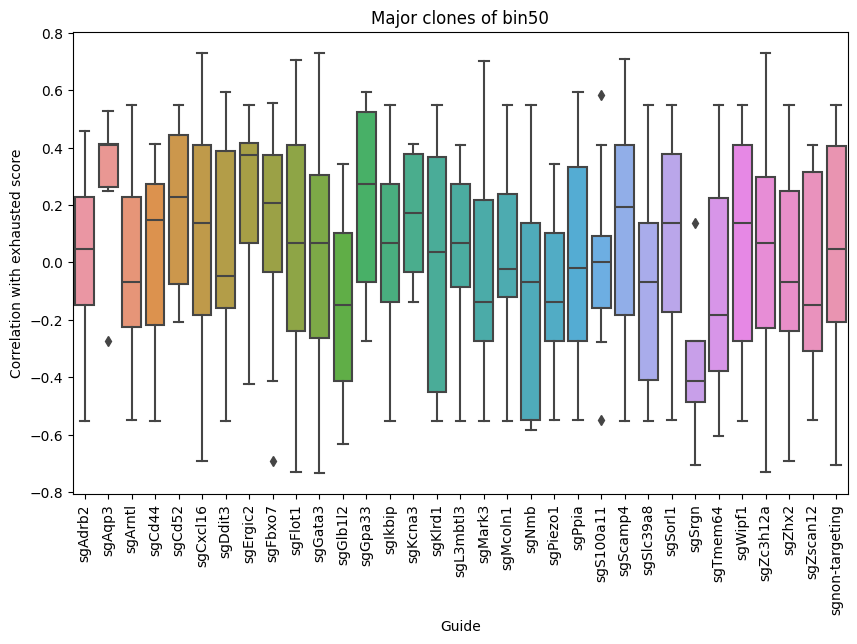

In [306]:
long_format_data = pd.DataFrame([(k, v) for k, lst in r_dict.items() for v in lst], columns=['guide', 'value'])

plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='guide', y='value', data=long_format_data)

plt.xlabel('Guide')
plt.ylabel('Correlation with exhausted score')
plt.title('Major clones of bin50')
plt.xticks(rotation=90)

plt.show()

In [308]:
guide = "sgGata3"
mask = cdata[:, guide].X > threshold

In [312]:
moran_df = pd.DataFrame(columns=["I", "p_value", "z_score"])
for i in tqdm(range(np.sum(mask))):
    major_clones = extract_bin20(cdata_bin50, cdata[mask][i])

    major_bin20_index = np.argmax(major_clones[:, "sgGata3"].X.toarray())
    box_ = find_near(major_clones[major_bin20_index], fdata_bin50, border=4, bin_size=20)

    spatial_coords = box_.obsm["spatial"]
    scores = box_.obs["memory T_score"].tolist()
    w = weights.DistanceBand.from_array(spatial_coords, threshold=51, binary=True)
    moran = esda.Moran(scores, w)

    moran_df.loc[i] = [moran.I, moran.p_sim, moran.z_sim]

100%|██████████| 119/119 [00:06<00:00, 17.49it/s]


In [313]:
guide_df = pd.DataFrame(columns=["I", "p_value", "z_score"])
for i in tqdm(range(np.sum(mask))):
    major_clones = extract_bin20(cdata_bin50, cdata[mask][i])

    major_bin20_index = np.argmax(major_clones[:, "sgGata3"].X.toarray())
    box_ = find_near(major_clones[major_bin20_index], cdata_bin20, border=4, bin_size=20)

    spatial_coords = box_.obsm["spatial"]
    scores = box_[:, "sgGata3"].X.toarray().flatten()
    w = weights.DistanceBand.from_array(spatial_coords, threshold=51, binary=True)
    moran = esda.Moran(scores, w)

    guide_df.loc[i] = [moran.I, moran.p_sim, moran.z_sim]

  0%|          | 0/119 [00:00<?, ?it/s]

100%|██████████| 119/119 [00:25<00:00,  4.69it/s]


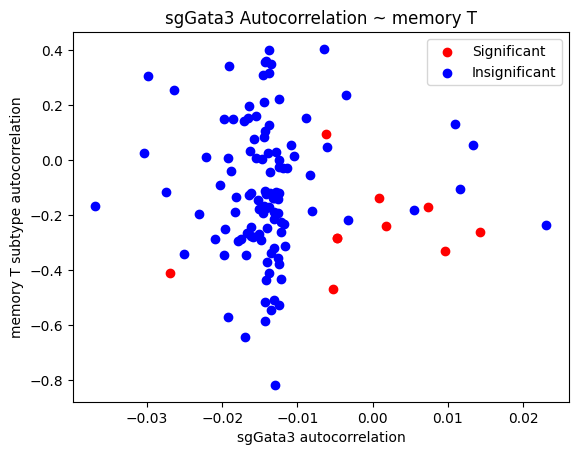

In [314]:
sig = guide_df["p_value"] < 0.1

plt.scatter(guide_df[sig]["I"], moran_df[sig]["I"], color="#FF0000", label="Significant")
plt.scatter(guide_df[~sig]["I"], moran_df[~sig]["I"], color="#0000FF", label="Insignificant")
plt.title("sgGata3 Autocorrelation ~ memory T")
plt.xlabel("sgGata3 autocorrelation")
plt.ylabel("memory T subtype autocorrelation")
plt.legend()
plt.show()

# Contour Map

In [328]:

from scipy.interpolate import griddata

In [417]:
def plot_contour(adata, score_name, ax, cmap="viridis", vmax=8):

    interest_sgene = "sgGlb1l2"
    interest_score = "Tex"

    apo_bin = adata.obs[score_name]
    hypo_coord = adata.obsm['spatial']
    coord_df = pd.DataFrame({
        'x_coord': hypo_coord[:, 0],
        'y_coord': hypo_coord[:, 1],
        'value': apo_bin
    })
    coord_df_piv = pd.pivot_table(coord_df, values="value", index="y_coord", columns="x_coord", aggfunc=np.mean)
    z = coord_df_piv.values
    y = coord_df_piv.index
    x = coord_df_piv.columns
    color_map = plt.get_cmap(cmap)

    new_cmap = mcolors.ListedColormap(color_map(np.linspace(0, 1, 100)))
    new_cmap.colors[:, -1] = np.linspace(0, 0.8, new_cmap.N)

    cs = ax.contourf(x, y, z, levels=vmax, cmap=new_cmap)
    plt.colorbar(cs, ax=ax, shrink=0.7)

def plot_dot(adata, gene_name, ax, color="Orange", square=True, alpha=0.2):
    x = adata.obsm["spatial"][:, 0]
    y = adata.obsm["spatial"][:, 1]
    a = adata[:, gene_name].X.toarray().flatten()
    if square is True:
        ax.scatter(x, y, s=np.square(a), alpha=alpha, color=color, label=gene_name)
    else:
        ax.scatter(x, y, s=a, alpha=alpha, color=color, lable=gene_name)

In [382]:
sc.tl.score_genes(fdata, gene_list=T_marker["exhausted T"], score_name="exhausted T_score")

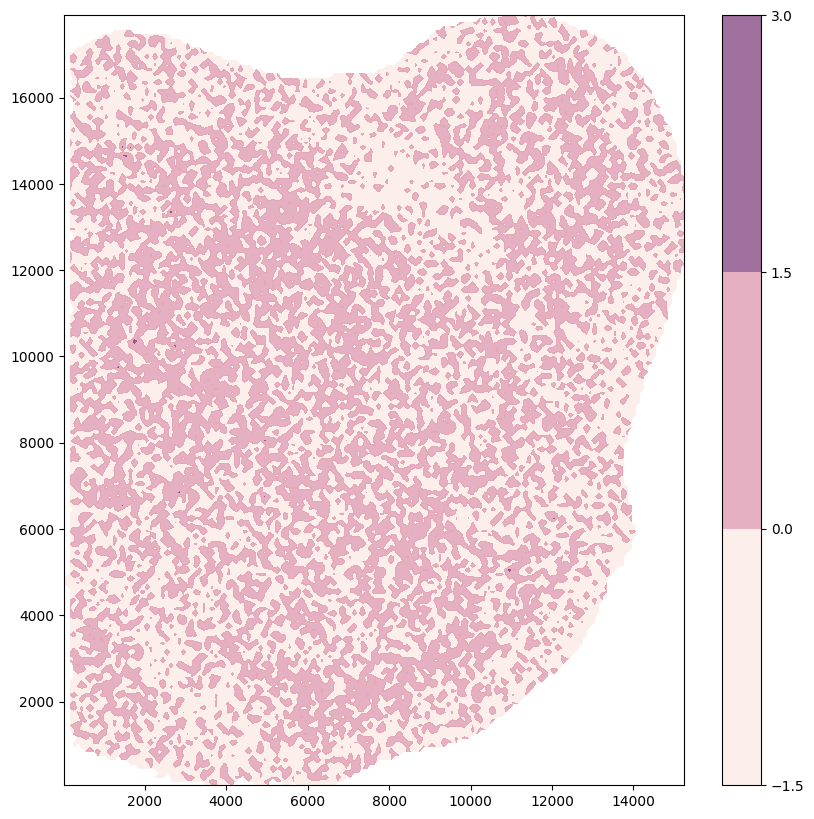

In [383]:
fig, ax=plt.subplots(1, 1, figsize=(10, 10))
plot_contour(fdata, score_name="exhausted T_score", ax=ax, cmap="flare", vmax=2)

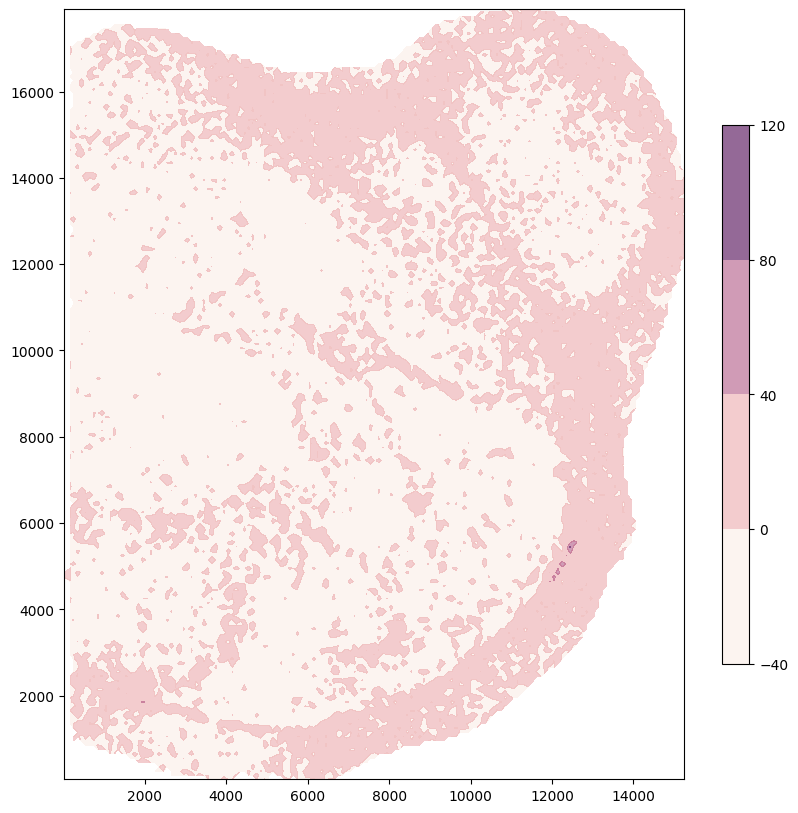

In [426]:
fig, ax=plt.subplots(1, 1, figsize=(10, 10))
plot_contour(fdata, score_name="collegen_score", ax=ax, cmap="flare", vmax=2)

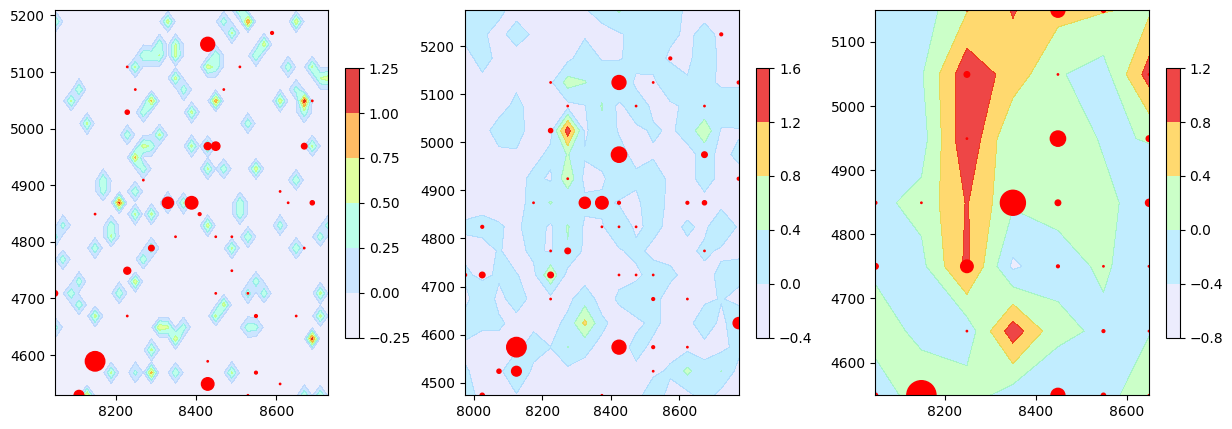

In [419]:
# 5x5 bin100 = 

i = 92
major_clones = extract_bin20(cdata_bin20, cdata[mask][i])
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
major_bin20_index = np.argmax(major_clones[:, "sgGata3"].X.toarray())
box_ = find_near(major_clones[major_bin20_index], fdata_bin20, border=17, bin_size=20)
plot_contour(box_, score_name="exhausted T_score", ax=ax[0], cmap="jet", vmax=4)
box_ = find_near(major_clones[major_bin20_index], cdata_bin20, border=17, bin_size=20)
#sq.pl.spatial_scatter(box_[(box_[:, "sgGata3"].X > 0)], color="sgGata3", size=100, shape=None, library_id="spatial", ax=ax[0])
plot_dot(box_[(box_[:, "sgGata3"].X > 0)], gene_name="sgGata3", ax=ax[0], color="Red", alpha=1)

major_clones = extract_bin20(cdata_bin50, cdata[mask][i])
major_bin50_index = np.argmax(major_clones[:, "sgGata3"].X.toarray())
box_ = find_near(major_clones[major_bin50_index], fdata_bin50, border=8, bin_size=50)
plot_contour(box_, score_name="exhausted T_score", ax=ax[1], cmap="jet", vmax=4)
box_ = find_near(major_clones[major_bin50_index], cdata_bin50, border=8, bin_size=50)
#sq.pl.spatial_scatter(box_[(box_[:, "sgGata3"].X > 0)], color="sgGata3", size=100, shape=None, library_id="spatial", ax=ax[1])
plot_dot(box_[(box_[:, "sgGata3"].X > 0)], gene_name="sgGata3", ax=ax[1], color="Red", alpha=1)

major_clones = extract_bin20(cdata, cdata[mask][i])
major_bin100_index = np.argmax(major_clones[:, "sgGata3"].X.toarray())
box_ = find_near(major_clones[major_bin100_index], fdata, border=3, bin_size=100)
plot_contour(box_, score_name="exhausted T_score", ax=ax[2], cmap="jet", vmax=4)
box_ = find_near(major_clones[major_bin100_index], cdata, border=3, bin_size=100)
#sq.pl.spatial_scatter(box_[(box_[:, "sgGata3"].X > 0)], color="sgGata3", size=100, shape=None, library_id="spatial", ax=ax[2])
plot_dot(box_[(box_[:, "sgGata3"].X > 0)], gene_name="sgGata3", ax=ax[2], color="Red", alpha=1)

In [421]:
sc.tl.score_genes(fdata, gene_list=["Col1a1", "Col1a2"], score_name="collegen_score")
sc.tl.score_genes(fdata_bin20, gene_list=["Col1a1", "Col1a2"], score_name="collegen_score")
sc.tl.score_genes(fdata_bin50, gene_list=["Col1a1", "Col1a2"], score_name="collegen_score")

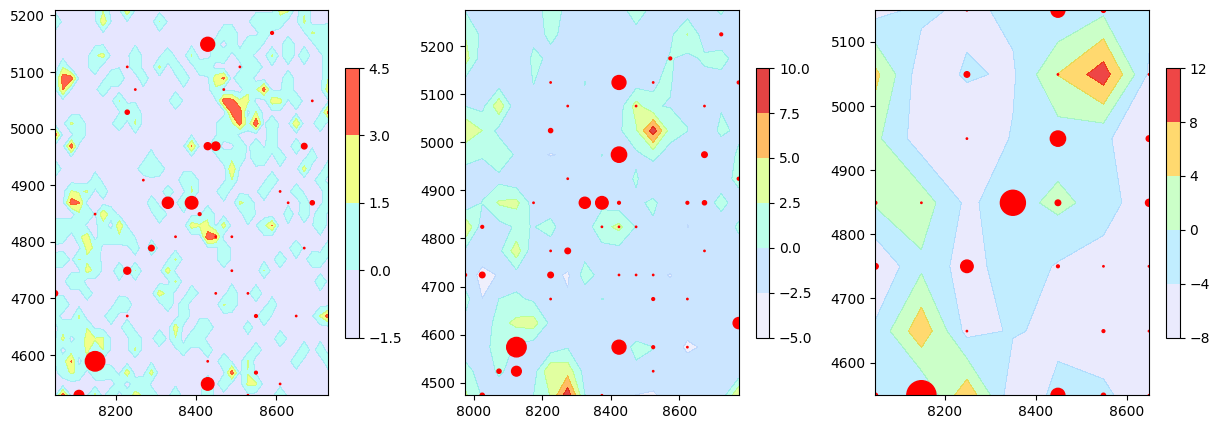

In [422]:
# 5x5 bin100 = 

i = 92
major_clones = extract_bin20(cdata_bin20, cdata[mask][i])
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
major_bin20_index = np.argmax(major_clones[:, "sgGata3"].X.toarray())
box_ = find_near(major_clones[major_bin20_index], fdata_bin20, border=17, bin_size=20)
plot_contour(box_, score_name="collegen_score", ax=ax[0], cmap="jet", vmax=4)
box_ = find_near(major_clones[major_bin20_index], cdata_bin20, border=17, bin_size=20)
#sq.pl.spatial_scatter(box_[(box_[:, "sgGata3"].X > 0)], color="sgGata3", size=100, shape=None, library_id="spatial", ax=ax[0])
plot_dot(box_[(box_[:, "sgGata3"].X > 0)], gene_name="sgGata3", ax=ax[0], color="Red", alpha=1)

major_clones = extract_bin20(cdata_bin50, cdata[mask][i])
major_bin50_index = np.argmax(major_clones[:, "sgGata3"].X.toarray())
box_ = find_near(major_clones[major_bin50_index], fdata_bin50, border=8, bin_size=50)
plot_contour(box_, score_name="collegen_score", ax=ax[1], cmap="jet", vmax=4)
box_ = find_near(major_clones[major_bin50_index], cdata_bin50, border=8, bin_size=50)
#sq.pl.spatial_scatter(box_[(box_[:, "sgGata3"].X > 0)], color="sgGata3", size=100, shape=None, library_id="spatial", ax=ax[1])
plot_dot(box_[(box_[:, "sgGata3"].X > 0)], gene_name="sgGata3", ax=ax[1], color="Red", alpha=1)

major_clones = extract_bin20(cdata, cdata[mask][i])
major_bin100_index = np.argmax(major_clones[:, "sgGata3"].X.toarray())
box_ = find_near(major_clones[major_bin100_index], fdata, border=3, bin_size=100)
plot_contour(box_, score_name="collegen_score", ax=ax[2], cmap="jet", vmax=4)
box_ = find_near(major_clones[major_bin100_index], cdata, border=3, bin_size=100)
#sq.pl.spatial_scatter(box_[(box_[:, "sgGata3"].X > 0)], color="sgGata3", size=100, shape=None, library_id="spatial", ax=ax[2])
plot_dot(box_[(box_[:, "sgGata3"].X > 0)], gene_name="sgGata3", ax=ax[2], color="Red", alpha=1)

Text(0.5, 1.0, 'Collegen Score ~ sgGata3')

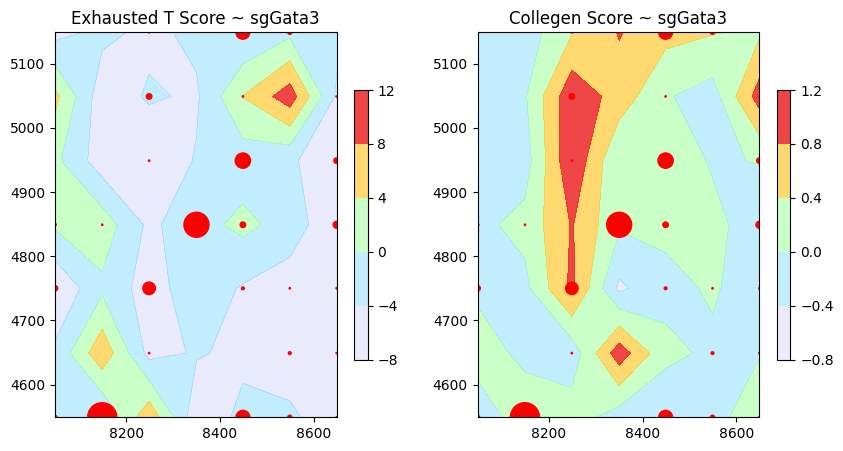

In [425]:

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
major_clones = extract_bin20(cdata, cdata[mask][i])
major_bin100_index = np.argmax(major_clones[:, "sgGata3"].X.toarray())
box_ = find_near(major_clones[major_bin100_index], fdata, border=3, bin_size=100)
plot_contour(box_, score_name="collegen_score", ax=ax[0], cmap="jet", vmax=4)
box_ = find_near(major_clones[major_bin100_index], cdata, border=3, bin_size=100)
#sq.pl.spatial_scatter(box_[(box_[:, "sgGata3"].X > 0)], color="sgGata3", size=100, shape=None, library_id="spatial", ax=ax[2])
plot_dot(box_[(box_[:, "sgGata3"].X > 0)], gene_name="sgGata3", ax=ax[0], color="Red", alpha=1)
ax[0].set_title("Exhausted T Score ~ sgGata3")
major_clones = extract_bin20(cdata, cdata[mask][i])
major_bin100_index = np.argmax(major_clones[:, "sgGata3"].X.toarray())
box_ = find_near(major_clones[major_bin100_index], fdata, border=3, bin_size=100)
plot_contour(box_, score_name="exhausted T_score", ax=ax[1], cmap="jet", vmax=4)
box_ = find_near(major_clones[major_bin100_index], cdata, border=3, bin_size=100)
#sq.pl.spatial_scatter(box_[(box_[:, "sgGata3"].X > 0)], color="sgGata3", size=100, shape=None, library_id="spatial", ax=ax[2])
plot_dot(box_[(box_[:, "sgGata3"].X > 0)], gene_name="sgGata3", ax=ax[1], color="Red", alpha=1)
ax[1].set_title("Collegen Score ~ sgGata3")